In [1]:
import matplotlib.pyplot as plt

import torch

from torchvision.datasets import CIFAR10
from torchvision import transforms

from torch.utils.data import DataLoader

from glow import GLOW

import normflows as nf

import torchvision as tv
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    nf.utils.Scale(255. / 256.)
])

train_data = CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True)

flow = GLOW(3, 32, (3, 32, 32), 10, 256)
flow.model.load_state_dict(torch.load('models/glow_cifar_3_32_256_54100.pt', map_location='cpu'))

Files already downloaded and verified


c:\Users\luana\AppData\Local\pypoetry\Cache\virtualenvs\lime-sohamHBj-py3.11\Lib\site-packages\torch\_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1994.)
  LU, pivots, infos = torch._lu_with_info(
C:\Users\luana\AppData\Local\Temp\ipykernel_43348\4001019606.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will ex

<All keys matched successfully>

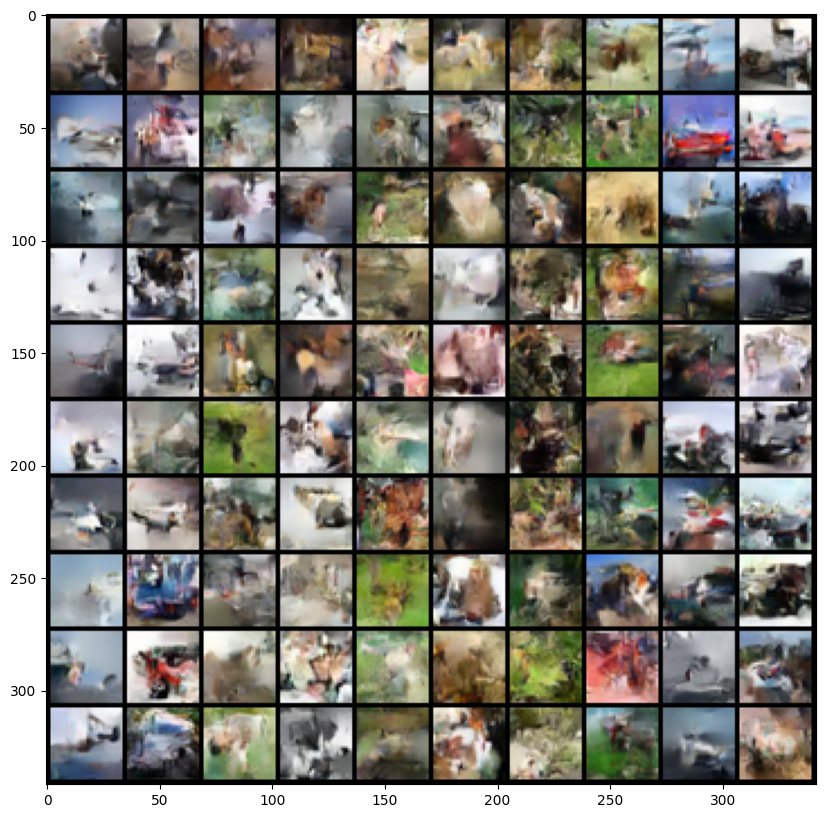

In [3]:
num_sample = 10

with torch.no_grad():
    y = torch.arange(10).repeat(num_sample)
    x, _ = flow.model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=10).cpu().numpy(), (1, 2, 0)))
    plt.show()

In [4]:
from PIL import Image

input_image = Image.open("data/puppykitty.jpg")

preprocess = transforms.Compose([
    transforms.Resize(48),
    transforms.CenterCrop(48),
    transforms.ToTensor(),
])
input_tensor = preprocess(input_image)
sample = input_tensor.unsqueeze(0)
latent = flow.to_latent(sample)
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet32", pretrained=True)
model.eval()

def print_top5(input_batch):

    with torch.no_grad():
        output = model(input_batch)

    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Read the categories
    with open("data/cifar10_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Show top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())


def counterfactual(flow, sample, target, confidence, lr=5e-3, max_iter=1000):
    # based on 'Diffeomorphic Explanations with Normalizing Flows', Dombrowski et. al
    latent = flow.to_latent(sample)

    latent[0] = latent[0].detach()
    latent[0].requires_grad = True

    model.eval()
    model.requires_grad_(False)

    flow.model.eval()
    flow.model.requires_grad_(False)
    optimizer = torch.optim.Adam([latent[0]], lr=lr)
    for i in range(max_iter):
        optimizer.zero_grad()
        x = flow.to_image(latent)[0]
        output = model(x)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        loss = -probs[target]
        print(f'Iteration {i}, loss: {loss.item()}', end='\r')
        loss.backward(retain_graph=True)
        optimizer.step()
        if probs[target] > confidence:
            break
    return flow.to_image(latent)

c:\Users\luana\Documents\lime\glow.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
Using cache found in C:\Users\luana/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


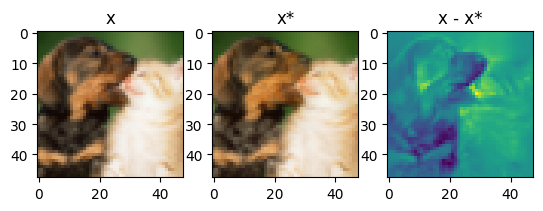

In [5]:
reconstructed = counterfactual(flow, sample, 3, 0.99)


plt.subplot(1, 3, 1)
plt.imshow(sample.squeeze().detach().numpy().transpose(1, 2, 0))
# subtitle
plt.title('x')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed[0].squeeze().detach().numpy().transpose(1, 2, 0))
plt.title('x*')
plt.subplot(1, 3, 3)
# for both immages, sum the absolute values of each color channel
sample_sum = torch.sum(torch.abs(sample), dim=1)
reconstructed_sum = torch.sum(torch.abs(reconstructed[0]), dim=1)
plt.imshow((sample_sum - reconstructed_sum).detach().numpy().transpose(1, 2, 0))
plt.title('x - x*')

plt.show()

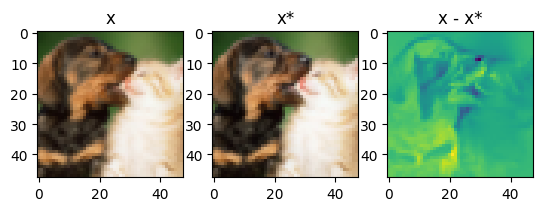

In [6]:
reconstructed = counterfactual(flow, sample, 5, 0.99)

plt.subplot(1, 3, 1)
plt.imshow(sample.squeeze().detach().numpy().transpose(1, 2, 0))
# subtitle
plt.title('x')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed[0].squeeze().detach().numpy().transpose(1, 2, 0))
plt.title('x*')
plt.subplot(1, 3, 3)
# for both immages, sum the absolute values of each color channel
sample_sum = torch.sum(torch.abs(sample), dim=1)
reconstructed_sum = torch.sum(torch.abs(reconstructed[0]), dim=1)
plt.imshow((sample_sum - reconstructed_sum).detach().numpy().transpose(1, 2, 0))
plt.title('x - x*')
plt.show()